In [1]:
from ipynb.fs.full.BreastFunctions import *
#from BreastFunctions_py import *
import numpy as np
import pandas as pd
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

%matplotlib qt

In [324]:
# Colors
def CreateColorMap(NumberofColors , colorsArray ):
    cmap = LinearSegmentedColormap.from_list('cmap', colorsArray, N=NumberofColors)
    return cmap
    
def CreateColorMap_Continuous(NumberofColors , colorsArray ):
    cvals = np.arange(0,NumberofColors-1)
    colors = colorsArray
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    
    return cmap

colorarray8=[ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo","#7f0000","#ff7f00"]
colorsarray7 = [ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo","#7f0000"]
colorsarray6 = [ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo"]
colorsarray5 = [ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia"]

colorsarrayTSNE = ["olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo","#7f0000","#ff7f00"]
colorsarray_5_TSNE = ["olivedrab","gold","darkturquoise", "wheat","fuchsia"]

cmap8 = CreateColorMap(9,colorarray8)
cmapTSNE= CreateColorMap(8,colorsarrayTSNE)

cmap7 = CreateColorMap(8,colorsarray7)
cmap6 = CreateColorMap(7,colorsarray6)

cmap5 = CreateColorMap(6,colorsarray5)
cmap5_TSNE = CreateColorMap(5,colorsarray_5_TSNE)

In [94]:
#Only load if needed to load total results from previous runs to continue on
total_results_dataframe_norm_SVM = pd.read_csv("total_breastCancer_results_norm_SVM.csv")
total_results_dataframe_norm_KNN = pd.read_csv("total_breastCancer_results_norm_KNN.csv")

# Prepare this dataframe (total results) only once
# total_results_dataframe_norm_SVM = pd.DataFrame(columns=["Patient to be predicted/left out" , "Metastasis-Free Subpopulation" , "Metastasis Subpopulation" , "Predicted Metastasis" ,
# "Metastasis Status", "Number of Clusters" , "SAM Features for each tSNE run on new subset"])

# total_results_dataframe_norm_KNN= pd.DataFrame(columns=["Patient to be predicted/left out" , "Metastasis-Free Subpopulation" , "Metastasis Subpopulation" , "Predicted Metastasis" ,
# "Metastasis Status", "Number of Clusters" ,"C Value" "SAM Features for each tSNE run on new subset"])



In [3]:
#Read Data
HE_image , MSI_data_cube , goodlist, peak_list, pixel_to_sample_ID, sample_only_data , sample_ID_pixels = ReadBreastData()

In [ ]:
# For loop run tSNE on patients
for i in range(21,33):
    ## Selecting Patient as test
    testPatient_ID = i
    #-------------------------------------------------------
    # Splitting data into train and test and scaled and non_scaled
    train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID ,
            sample_only_data = sample_only_data,
            sample_ID_pixels = sample_ID_pixels )

    scaler = MinMaxScaler()
    train_normalized_data = scaler.fit_transform(train_data)

    # Run tSNE Model
    tsne_results = tSNE(train_normalized_data)
    np.save("patient_TSNE/BreastCancer_tSNE_Normalized_Model_Patient_{}".format(testPatient_ID) , tsne_results)

In [326]:
## Selecting Patient as test
testPatient_ID = 12
#-------------------------------------------------------

# Splitting data into train and test and scaled and non_scaled
train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID ,
        sample_only_data = sample_only_data,
        sample_ID_pixels = sample_ID_pixels )

In [327]:
tsne_results = np.load("patient_TSNE/BreastCancer_tSNE_Normalized_Model_Patient_{}.npy".format(testPatient_ID))

In [ ]:
# tSNE dataframe to visualize in 2D and 3D

tsne_df = pd.DataFrame(data=tsne_results[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
tsne_df['pixel_ID'] = train_ID_pixels
tsne_df['L_Component'] = tsne_results[:,0]
tsne_df['A_Component'] = tsne_results[:,1]
tsne_df['B_Component'] = tsne_results[:,2]

LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
LAB_colors = np.asarray(LAB_mapping)
LAB_colors = LAB_colors.swapaxes(0,1)

L = rescale(LAB_colors[:,0]) * 100
A = rescale_AB(LAB_colors[:,1])
B = rescale_AB(LAB_colors[:,2])
LAB_colors = np.asarray( [ L , A, B ] )
LAB_colors = LAB_colors.swapaxes(0,1)
RGB_colors = lab2rgb(LAB_colors)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})
marker_size = 9

sns.scatterplot(
    ax = axes[0],
    x = "tSNE_dim1", y="tSNE_dim2",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[0].set_title("tSNE Dimension 1 & tSNE Dimension 2 Plot")

sns.scatterplot(
    ax = axes[1],
    x = "tSNE_dim1", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[1].set_title("tSNE Dimension 1 & tSNE Dimension 3 Plot")

sns.scatterplot(
    ax = axes[2],
    x = "tSNE_dim2", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[2].set_title("tSNE Dimension 2 & tSNE Dimension 3 Plot")



plt.tight_layout()
plt.show()



In [296]:
# tSNE visualized in 3D
%matplotlib qt
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'],
    zs= tsne_df['tSNE_dim3'],
    c = RGB_colors,
    s = 5,
    alpha = 1,
)
# ax.set_xlim(-40,40)
# ax.set_ylim(-40,40)
# ax.set_zlim(-40,40)
ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Colored map")

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()

In [328]:
kmeans_10,kmeans_9, kmeans_8 , kmeans_7, kmeans_6, kmeans_5, kmeans_4, kmeans_3= KMeans_results(tsne_results)

In [ ]:
# kMeans tSNE
tsne_visualized_labels = kmeans_8.labels_
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = tsne_visualized_labels,
    cmap = cmapTSNE,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Colored map for {} components".format(len(np.unique(tsne_visualized_labels))))


# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 30 , azim = -150) 
plt.tight_layout()

In [329]:
# Read Clinical Data
Clinical_data = ReadClinicalData(testPatient_ID , "ClinicalData.xlsx")
Clinical_data_full = pd.read_excel("ClinicalData.xlsx","Breast Cancer Clinical Data")

NonMetastasis: [4. 0. 6. 1. 1. 2. 1. 0. 2. 1.]
Metastasis: [ 2. 11.  2.  1.  1.  4.  3.  5.  4.  4.]


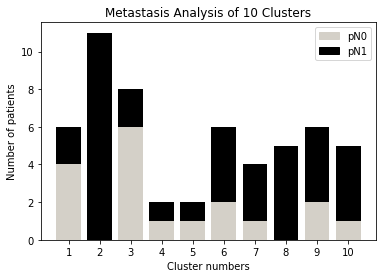

NonMetastasis: [1. 1. 0. 2. 1. 1. 2. 6. 4.]
Metastasis: [ 4.  1. 10.  4.  4.  3.  5.  2.  2.]


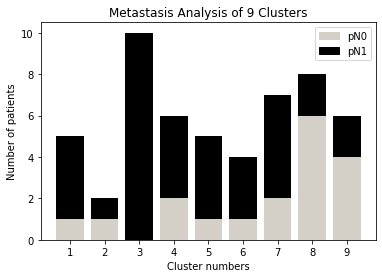

NonMetastasis: [1. 0. 3. 2. 2. 6. 1. 4.]
Metastasis: [3. 9. 5. 4. 3. 2. 1. 3.]


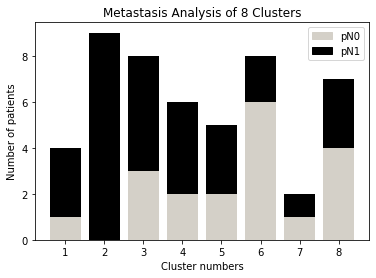

NonMetastasis: [1. 4. 0. 4. 3. 4. 2.]
Metastasis: [1. 3. 9. 2. 3. 5. 5.]


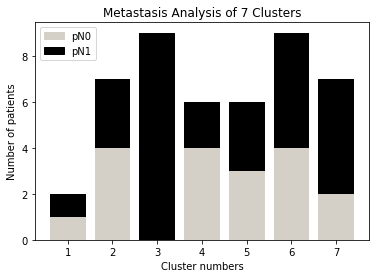

NonMetastasis: [1. 4. 3. 4. 2. 1.]
Metastasis: [ 1.  3.  3.  3.  5. 10.]


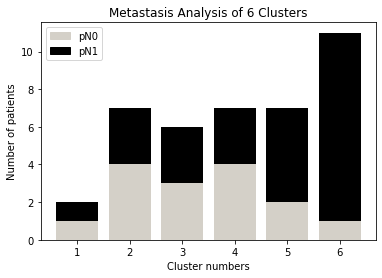

NonMetastasis: [2. 4. 4. 2. 3.]
Metastasis: [ 4.  5.  1. 10.  5.]


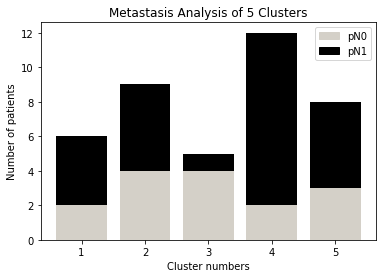

NonMetastasis: [4. 4. 4. 1.]
Metastasis: [6. 5. 2. 9.]


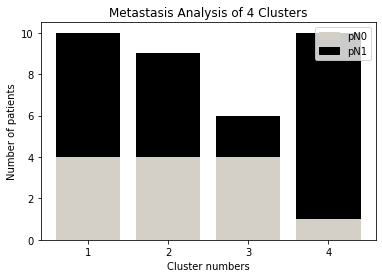

NonMetastasis: [5. 3. 3.]
Metastasis: [ 5.  7. 10.]


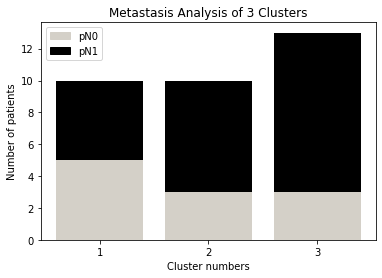

In [330]:
# Plots Non-Metastasis and Metastasis clusters

%matplotlib inline

state010, state110 = metastasis_status(kmeans_10.labels_, Clinical_data,train_ID_pixels)
state09, state19 = metastasis_status(kmeans_9.labels_, Clinical_data,train_ID_pixels)
state08, state18 = metastasis_status(kmeans_8.labels_, Clinical_data,train_ID_pixels)
state07, state17 = metastasis_status(kmeans_7.labels_, Clinical_data,train_ID_pixels)
state06, state16 = metastasis_status(kmeans_6.labels_, Clinical_data,train_ID_pixels)
state05, state15 = metastasis_status(kmeans_5.labels_, Clinical_data,train_ID_pixels)
state04, state14 = metastasis_status(kmeans_4.labels_, Clinical_data,train_ID_pixels)
state03, state13 = metastasis_status(kmeans_3.labels_, Clinical_data,train_ID_pixels)

# Plots bar plot of Non-Metastasis and Metastasis clusters
plot_metastasis_status(state010, state110)
plot_metastasis_status(state09, state19)
plot_metastasis_status(state08, state18)
plot_metastasis_status(state07, state17)
plot_metastasis_status(state06, state16)
plot_metastasis_status(state05, state15)
plot_metastasis_status(state04, state14)
plot_metastasis_status(state03, state13)

# Create dict to save kmeans results and select them later
kmeans_dict = {"10_Clusters": [kmeans_10.labels_,state010],"9_Clusters": [kmeans_9.labels_,state09], "8_Clusters": [kmeans_8.labels_,state08] , "7_Clusters": [kmeans_7.labels_,state07]  , "6_Clusters": [kmeans_6.labels_,state06] , "5_Clusters": [kmeans_5.labels_,state05], "4_Clusters": [kmeans_4.labels_,state04], "3_Clusters": [kmeans_3.labels_,state03]}

In [366]:
# Select the correct kmeans that shows best results from metastasis analysis, must have one fully metastasis cluster
selected_clusters_value = 7

# ----------------------------------------------------------------------------------

# Detect the fully metastasis cluster, select the correct kmeans that shows best results from metastasis analysis
labels = kmeans_dict[str(selected_clusters_value)+"_Clusters"][0]
selected_state = kmeans_dict[str(selected_clusters_value)+"_Clusters"][1]

fully_metastasis_cluster_label = 0
for cluster in selected_state:
    if not cluster: # Cluster list is empty, has no healthy patients, so it's fully metastasis cluster
        break # fully_metastasis_cluster_label now has the right label, exit loop
    
    fully_metastasis_cluster_label += 1

print("Fully metastasis cluster label's index is {} and it is cluster {}".format(fully_metastasis_cluster_label,fully_metastasis_cluster_label+1))

Fully metastasis cluster label's index is 2 and it is cluster 3


In [367]:
# Run R file in order to generate significant proteins using the csv file
protein_dataframe = SAM_Analysis(labels, Clinical_data, train_ID_pixels, fully_metastasis_cluster_label, train_data, peak_list)
protein_dataframe.to_csv("BreastCancerAverageSpectrumValues.csv",index=False)

In [370]:
#Need to read significant protein file outputted from R

SAM_protein = readSignificantProteins("significant_breast_proteins.json",delete=False)
SAM_protein = SAM_protein + readSignificantProteins("significant_breast_proteins_up.json",delete=False)

SAM_protein_indices=[]
for i in range(len(peak_list)):

    if peak_list[i][0] in SAM_protein:
        SAM_protein_indices.append(i)

train_scaled_selected_proteins_data = train_scaled_data[:,SAM_protein_indices]
test_scaled_selected_proteins_data = test_scaled_data[:,SAM_protein_indices]

train_selected_proteins_data = train_data[:,SAM_protein_indices]
test_selected_proteins_data = test_data[:,SAM_protein_indices]

train_labels = TargetLabelsCreation(labels , Clinical_data, train_ID_pixels, fully_metastasis_cluster_label)

In [371]:
SAM_protein

[4965, 4999, 5171, 5067, 6980, 4620]

In [321]:
# Visilizing protein 
protein_ion = 6650
protein_index = protein_dataframe.columns.get_loc(protein_ion)

In [ ]:
# Visilizing protein 
cmhot = plt.get_cmap("hot") #name of cmap u want from matplotlib

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = train_data[:,protein_index],
    cmap = cmhot,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')


# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 30 , azim = -150) 
plt.tight_layout()

In [ ]:
# Visilizing protein 
cmap_red_black = CreateColorMap(2,["red","black"])

fully_metastasis_labels = copy.deepcopy(labels)
fully_metastasis_indices = np.where(labels == fully_metastasis_cluster_label)[0]
fully_metastasis_labels[fully_metastasis_indices] = -1
fully_metastasis_labels[fully_metastasis_labels != -1] = 0

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = fully_metastasis_labels,
    cmap = cmap_red_black,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')


# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 30 , azim = -150) 
plt.tight_layout()

In [372]:
# Test rbf at c = 0.1 , 1 , 10
# Test linear at c = 0.1 , 1 , 10
C_value= 0.1
y_pred_SVM = SVM("rbf" , C_value , train_selected_proteins_data , train_labels , test_selected_proteins_data)

In [373]:
Metastasis_prob, Non_Metastasis_prob = ProbabilityCalc(y_pred_SVM)
Surv_SVM = [Metastasis_prob , Non_Metastasis_prob]

Metastasis probability : 22.230483271375466 
Non-Metastasis probability : 77.76951672862454


In [374]:
K_value= 2
y_pred_KNN = KNN(K_value, train_selected_proteins_data, train_labels, test_selected_proteins_data)
# 2 , 4 , 8 , 6

In [375]:
Metastasis_prob, Non_Metastasis_prob = ProbabilityCalc(y_pred_KNN)
Surv_KNN = [Metastasis_prob , Non_Metastasis_prob]

Metastasis probability : 11.301115241635689 
Non-Metastasis probability : 88.69888475836431


In [376]:
# Selected Gastric probabilities, select KNN or SVM results
Selected_model = Surv_SVM
Metastasis_prob = round(Selected_model[0],2)
Non_Metastasis_prob = round(Selected_model[1],2)

In [377]:
# Run after model complete to save the result in the total results dataframe
total_results_dataframe_norm_SVM = OutputDataframe(total_results_dataframe_norm_SVM, testPatient_ID , Clinical_data_full, Non_Metastasis_prob, Metastasis_prob, selected_clusters_value,C_value, SAM_protein)

In [378]:
total_results_dataframe_norm_SVM

,Patient to be predicted/left out,Metastasis-Free Subpopulation,Metastasis Subpopulation,Predicted Metastasis,Metastasis Status,Number of Clusters,SAM Features for each tSNE run on new subset,C Value
0,3,100.000000,0.000000,1,1,6,"Significant Features : m/z = [4965, 4999, 5171...",0.1
1,3,98.408602,1.591398,1,1,6,"Significant Features : m/z = [4965, 4999, 5171...",1.0
2,5,99.733901,0.266099,1,1,6,"Significant Features : m/z = [5171, 4965, 4999...",0.1
3,11,100.000000,0.000000,1,1,8,"Significant Features : m/z = [4965, 5171, 4999...",0.1
4,11,99.880668,0.119332,1,1,8,"Significant Features : m/z = [4965, 5171, 4999...",1.0
5,16,27.466151,72.533849,2,2,8,"Significant Features : m/z = [4999, 11652, 496...",0.1
6,16,19.729207,80.270793,2,2,5,"Significant Features : m/z = [4999, 4965, 5171...",1.0
7,19,41.871921,58.128079,2,2,8,"Significant Features : m/z = [6277, 11652, 499...",0.1
8,2,91.451991,8.548009,2,1,7,"Significant Features : m/z = [6650, 6277, 6980...",5.0
0,4,99.940000,0.060000,1,1,6,"Significant Features : m/z = [4965, 5171, 4999...",0.1


In [379]:
total_results_dataframe_norm_SVM.to_csv("total_breastCancer_results_norm_SVM.csv" , index = False)

In [380]:
Selected_model = Surv_KNN
Metastasis_prob = round(Selected_model[0],2)
Non_Metastasis_prob = round(Selected_model[1],2)

In [381]:
total_results_dataframe_norm_KNN = OutputDataframe(total_results_dataframe_norm_KNN, testPatient_ID , Clinical_data_full, Non_Metastasis_prob, Metastasis_prob, selected_clusters_value,K_value, SAM_protein)

In [382]:
total_results_dataframe_norm_KNN

,Patient to be predicted/left out,Metastasis-Free Subpopulation,Metastasis Subpopulation,Predicted Metastasis,Metastasis Status,Number of Clusters,C ValueSAM Features for each tSNE run on new subset,C Value,SAM Features for each tSNE run on new subset
0,3,86.580645,13.419355,2,1,6,NaN,0,"Significant Features : m/z = [4965, 4999, 5171..."
1,5,99.201703,0.798297,1,1,6,NaN,0,"Significant Features : m/z = [5171, 4965, 4999..."
2,11,98.926014,1.073986,1,1,8,NaN,0,"Significant Features : m/z = [4965, 5171, 4999..."
3,16,20.083817,79.916183,2,2,8,NaN,0,"Significant Features : m/z = [4999, 11652, 496..."
4,19,33.638283,66.361717,2,2,8,NaN,5,"Significant Features : m/z = [6277, 11652, 499..."
5,2,90.632318,9.367681,2,1,7,NaN,2,"Significant Features : m/z = [6650, 6277, 6980..."
0,4,93.610000,6.390000,2,1,6,NaN,2,"Significant Features : m/z = [4965, 5171, 4999..."
0,6,92.720000,7.280000,2,1,9,NaN,2,"Significant Features : m/z = [4999, 4965, 5171..."
0,7,92.110000,7.890000,2,1,7,NaN,2,"Significant Features : m/z = [4999, 4965, 5067..."
0,7,99.500000,0.500000,1,1,10,NaN,2,"Significant Features : m/z = [4965, 5171, 4999..."


In [383]:
total_results_dataframe_norm_KNN.to_csv("total_breastCancer_results_norm_KNN.csv" , index = False)